# COMP47590: Advanced Machine Learning
# Assignment 2: Pneumonia Detection

Name(s): **Gursimar Preet Singh**, **Sayli Shrivastav** 

Student Number(s): **18205665**, **19204505**


### Importing the required libraries 

In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.utils import np_utils
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, adam
from keras import backend as K
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
import itertools
from keras.layers.normalization import BatchNormalization
from keras.models import load_model


from sklearn.metrics import confusion_matrix
import sklearn
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score

from IPython.display import SVG

import csv
import os 
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline 
import scipy as sp
import PIL

# Task 1: Data Loading

The dataset containg the chest x_ray images are loaded. The images are converted into grayscale and resized to 162*128.

In [2]:
sample_rate = 1.0
img_width, img_height = 162,128

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [3]:
def image_data(dataset_path):
    X_data = np.ndarray((0, img_width, img_height), dtype=np.float)
    y_data= np.ndarray(0, dtype=np.str)
    class_folders = [i for i in os.listdir(dataset_path) if not i.startswith('.')] # use this for full dataset
    num_classes = len(class_folders)
    
    for i, image_cls in enumerate(class_folders):

          print('Processing class {}'.format(image_cls))
          image_class_folder = dataset_path + image_cls + "/"

          # generate filenames from the data folder and do sampling
          image_filenames = [image_class_folder+i for i in os.listdir(image_class_folder) if not i.startswith('.')] # use this for full dataset
          image_filenames = random.sample(image_filenames, int(len(image_filenames)*sample_rate))

          count = len(image_filenames)

          X_data_part = np.ndarray((count, img_width, img_height), dtype=np.float)

          # Iterate throuigh the filenames and for each one load the image, resize and normalise
          for i, image_file in enumerate(image_filenames):

              # Low the images and resize them
              image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)
              image = cv2.resize(image, (img_height, img_width), interpolation=cv2.INTER_AREA)

              # Add image data to data array and normalise
              X_data_part[i] = image
              X_data_part[i] = X_data_part[i]/255

              # Add label to label array
              y_data = np.append(y_data, image_cls)

          # Append the part to the overall data array
          X_data = np.append(X_data, X_data_part, axis=0)
    return(X_data,y_data, num_classes)



# Task 2: Logistic Regression 

### Train set and test set

In [4]:
X_data, y_data, num_classes = image_data('train/')
X_test_data, y_test_data, num_classes = image_data('test/')

Processing class PNEUMONIA
Processing class NORMAL
Processing class PNEUMONIA
Processing class NORMAL


### Printing a few images from the training set

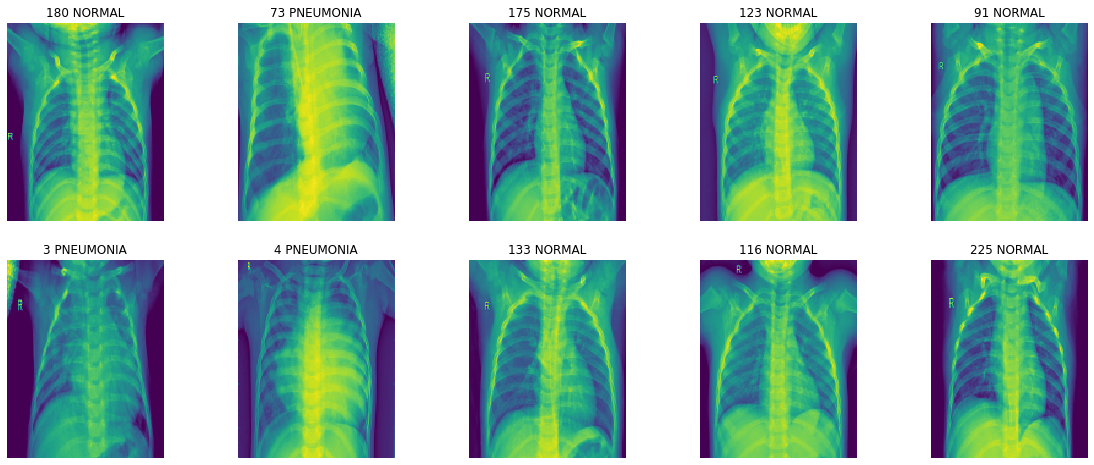

In [5]:
#printing some images
pltsize=4
row_images = 2
col_images = 5
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, X_data.shape[0])
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(PIL.Image.fromarray(((X_data[i_rand]) * 255).astype(np.uint8)))
    plt.title((str(i_rand) + " " + y_data[i_rand]))

Splitting into training set and validation set.

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_data, y_data,shuffle=True, random_state=0,train_size = 0.7)      

In [7]:
dataset_path = 'train/'
label_encoder =  sklearn.preprocessing.LabelEncoder()
class_labels = [i for i in os.listdir(dataset_path) if not i.startswith('.')]
data_encoder = label_encoder.fit(class_labels)

In [8]:
y_train_encoded = data_encoder.transform(y_train)
y_valid_encoded = data_encoder.transform(y_valid)
y_test_encoded = data_encoder.transform(y_test_data)

In [9]:
vector_dim = img_height * img_width
X_train_vector = np.zeros(shape=(X_train.shape[0],vector_dim))
X_valid_vector = np.zeros(shape=(X_valid.shape[0],vector_dim))
X_test_vector = np.zeros(shape=(X_test_data.shape[0],vector_dim))

In [10]:
# reshaping train, valid, test data
for i in range(X_train.shape[0]):
  X_train_vector[i] = np.reshape(X_train[i],(1,vector_dim))

for i in range(X_valid.shape[0]):
  X_valid_vector[i] = np.reshape(X_valid[i],(1,vector_dim))

for i in range(X_test_data.shape[0]):
  X_test_vector[i] = np.reshape(X_test_data[i],(1,vector_dim))  

### Training the model

In [11]:
clf = LogisticRegression(n_jobs = -1)
clf = clf.fit(X_train_vector,y_train_encoded)

/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/sahil/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


### Prediction on validation set

In [15]:
#Predtion on validation set
print("Validation Set:")
y_pred = clf.predict(X_valid_vector)
print("Classification report: ")
print(sklearn.metrics.classification_report(y_valid_encoded, y_pred))
print("Accuracy: ", round(sklearn.metrics.accuracy_score(y_valid_encoded,y_pred)*100))

Validation Set:
Classification report: 
              precision    recall  f1-score   support

           0       0.94      0.98      0.96        48
           1       0.95      0.86      0.90        21

    accuracy                           0.94        69
   macro avg       0.94      0.92      0.93        69
weighted avg       0.94      0.94      0.94        69

Accuracy:  94.0


### Prediction on test set

In [17]:
print("Test Set:")
y_pred_test = clf.predict(X_test_vector)
print("Classification report: ")
print(sklearn.metrics.classification_report(y_test_encoded, y_pred_test))
print("Accuracy: ", round(sklearn.metrics.accuracy_score(y_test_encoded,y_pred_test)*100))


Test Set:
Classification report: 
              precision    recall  f1-score   support

           0       0.73      0.76      0.74       234
           1       0.85      0.83      0.84       390

    accuracy                           0.80       624
   macro avg       0.79      0.79      0.79       624
weighted avg       0.81      0.80      0.81       624

Accuracy:  80.0


### Confusion matrix 

In [18]:
display(pd.crosstab(y_test_encoded, y_pred_test, rownames=['True'],colnames = ['Predicted'], margins = True))

Predicted,0,1,All
True,,,
0,177,57,234
1,65,325,390
All,242,382,624


# Task 3: Training a Conolution Neural Network model

### Loading the images
We are using ImageDataGenerator class in keras. It Generate batches of tensor image data. The data is looped over in batches.

In [21]:
train_path = 'train'
test_path = 'test'
generator = ImageDataGenerator(validation_split=0.3, rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
img_height, img_width = 162,128

In [22]:
print("Training Set")
train_batches = generator.flow_from_directory(directory=train_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'], color_mode='grayscale', batch_size=16, subset='training', shuffle=True, seed=20)

print("Validation Set")
valid_batches = generator.flow_from_directory(directory=train_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'],color_mode='grayscale', batch_size=16, subset='validation', shuffle=True, seed=20)

print("Test Set")
test_batches = test_gen.flow_from_directory(directory=test_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'],color_mode='grayscale', batch_size=1, shuffle=False, seed=20)

Training Set
Found 162 images belonging to 2 classes.
Validation Set
Found 67 images belonging to 2 classes.
Test Set
Found 624 images belonging to 2 classes.


### Creating the model

In [23]:
model_2 = Sequential()
model_2.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='tanh', input_shape=(162,128,1)))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=2))
model_2.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='tanh'))
model_2.add(MaxPooling2D(pool_size=(2,2), strides=2))
model_2.add(Flatten())
model_2.add(Dense(120, activation='tanh'))
model_2.add(Dense(84, activation='tanh'))
model_2.add(Dense(2, activation='softmax'))

In [24]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 162, 128, 6)       156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 81, 64, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 77, 60, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 38, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               2188920   
_________________________________________________________________
dense_2 (Dense)              (None, 84)               

### Training the model

In [25]:
model_2.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc']) #compiling the model

In [26]:
best_weights_filepath = 'best_weights_CNN.hdf5'   #saving the best weights
checkpoint = ModelCheckpoint(best_weights_filepath, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [27]:
STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

In [28]:
train_batches.reset()
valid_batches.reset()
history_1 = model_2.fit_generator(train_batches, steps_per_epoch= STEP_SIZE_TRAIN,
                                  validation_data = valid_batches, 
                                  validation_steps = STEP_SIZE_VALID, epochs=15, verbose=1, callbacks = [checkpoint])

Epoch 1/15
10/10 [==============================] - 2s 250ms/step - loss: 0.9157 - acc: 0.6301 - val_loss: 0.7497 - val_acc: 0.3594

Epoch 00001: loss improved from inf to 0.99034, saving model to best_weights_CNN.hdf5
Epoch 2/15
10/10 [==============================] - 2s 238ms/step - loss: 0.6429 - acc: 0.6027 - val_loss: 0.6950 - val_acc: 0.6863

Epoch 00002: loss improved from 0.99034 to 0.63514, saving model to best_weights_CNN.hdf5
Epoch 3/15
10/10 [==============================] - 2s 222ms/step - loss: 0.5655 - acc: 0.6750 - val_loss: 0.4831 - val_acc: 0.7647

Epoch 00003: loss improved from 0.63514 to 0.56545, saving model to best_weights_CNN.hdf5
Epoch 4/15
10/10 [==============================] - 2s 172ms/step - loss: 0.4296 - acc: 0.9167 - val_loss: 0.5570 - val_acc: 0.8039

Epoch 00004: loss improved from 0.56545 to 0.44314, saving model to best_weights_CNN.hdf5
Epoch 5/15
10/10 [==============================] - 2s 175ms/step - loss: 0.4150 - acc: 0.8973 - val_loss: 0.393

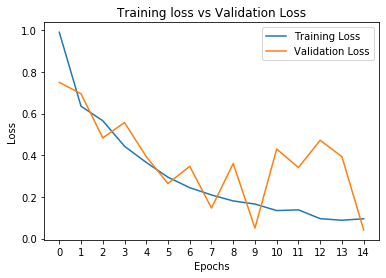

In [29]:
epochs = 15

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
plt.title("Training loss vs Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(0,epochs)[0::1])
plt.legend()
plt.show()

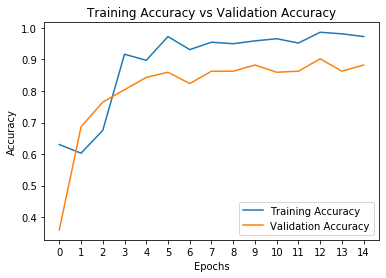

In [101]:
loss = history_1.history['acc']
val_loss = history_1.history['val_acc']
plt.title("Training Accuracy vs Validation Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(loss, label='Training Accuracy')
plt.plot(val_loss, label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::1])
plt.legend()
plt.show()

In [42]:
model_2 = load_model('best_weights_CNN.hdf5') #loading the best model
model_2.evaluate_generator(generator=test_batches,steps=624)

[1.3119012117385864, 0.8221153616905212]

### Testing the model

In [43]:
test_batches.reset()
pred = np.argmax(model_2.predict_generator(test_batches,steps=624),axis=1)

In [44]:
actual_labels = (test_batches.labels)

In [98]:
scores = model_2.evaluate_generator(generator=test_batches,steps=624)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 1.3119012117385864
Test accuracy: 0.8221153616905212


### Evaluating the model

In [46]:
print(metrics.classification_report(actual_labels, pred))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79       234
           1       0.93      0.77      0.84       390

    accuracy                           0.82       624
   macro avg       0.82      0.84      0.82       624
weighted avg       0.85      0.82      0.82       624



### Confusion Matrix

In [48]:
print("Confusion Matrix:")
display(pd.crosstab(actual_labels, pred, rownames=["True"],colnames = ['Predicted'], margins = True))

Confusion Matrix:


Predicted,0,1,All
True,,,
0,212,22,234
1,89,301,390
All,301,323,624


# Task 4: CNN with Data Augmentation

In [49]:
aug = ImageDataGenerator(brightness_range=[1,2],zoom_range=0.2, rotation_range=40, validation_split=0.3,rescale=1./255)
gen = ImageDataGenerator(rescale=1./255)


In [50]:
print("Training Set")
train_imageGen = aug.flow_from_directory(directory=train_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'], color_mode='grayscale', batch_size=16, subset='training', shuffle=True, seed=20)

print("Validation Set")
valid_imageGen = aug.flow_from_directory(directory=train_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'], color_mode='grayscale', batch_size=1, subset='validation', shuffle=True, seed=20)


print("Test Set")
test_imageGen = gen.flow_from_directory(directory=test_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'],color_mode='grayscale', batch_size=1, shuffle=False, seed=20)

Training Set
Found 162 images belonging to 2 classes.
Validation Set
Found 67 images belonging to 2 classes.
Test Set
Found 624 images belonging to 2 classes.


### Creating a model

In [51]:
model_aug = Sequential()
model_aug.add(Conv2D(filters=6, kernel_size=(5,5), padding='same', activation='tanh', input_shape=(162,128,1)))
model_aug.add(MaxPooling2D(pool_size=(2,2), strides=2))
model_aug.add(Conv2D(filters=16, kernel_size=(5,5), padding='valid', activation='tanh'))
model_aug.add(MaxPooling2D(pool_size=(2,2), strides=2))
model_aug.add(Flatten())
model_aug.add(Dense(120, activation='tanh'))
model_aug.add(Dense(84, activation='tanh'))
model_aug.add(Dense(2, activation='softmax'))

In [52]:
model_aug.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 162, 128, 6)       156       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 81, 64, 6)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 77, 60, 16)        2416      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 38, 30, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 18240)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               2188920   
_________________________________________________________________
dense_5 (Dense)              (None, 84)               

### Training the model

In [53]:
model_aug.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['acc']) #compiling the model

In [54]:
best_weights_filepath = 'best_weights_CNN_aug.hdf5' #saving the best weights
checkpoint = ModelCheckpoint(best_weights_filepath, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [55]:
train_imageGen.reset()
valid_imageGen.reset()
history_aug = model_aug.fit_generator(train_imageGen, steps_per_epoch= 11,
                                  validation_data = valid_imageGen, 
                                  validation_steps = 67, epochs=15, verbose=1, callbacks = [checkpoint])

Epoch 1/15
11/11 [==============================] - 4s 357ms/step - loss: 0.7116 - acc: 0.6235 - val_loss: 0.6041 - val_acc: 0.6269

Epoch 00001: loss improved from inf to 0.74020, saving model to best_weights_CNN_aug.hdf5
Epoch 2/15
11/11 [==============================] - 2s 201ms/step - loss: 0.5408 - acc: 0.7469 - val_loss: 0.7673 - val_acc: 0.7612

Epoch 00002: loss improved from 0.74020 to 0.52600, saving model to best_weights_CNN_aug.hdf5
Epoch 3/15
11/11 [==============================] - 2s 209ms/step - loss: 0.5135 - acc: 0.7407 - val_loss: 0.0644 - val_acc: 0.6716

Epoch 00003: loss improved from 0.52600 to 0.50699, saving model to best_weights_CNN_aug.hdf5
Epoch 4/15
11/11 [==============================] - 2s 211ms/step - loss: 0.4653 - acc: 0.7407 - val_loss: 0.9666 - val_acc: 0.6866

Epoch 00004: loss improved from 0.50699 to 0.48816, saving model to best_weights_CNN_aug.hdf5
Epoch 5/15
11/11 [==============================] - 2s 210ms/step - loss: 0.3867 - acc: 0.8086 -

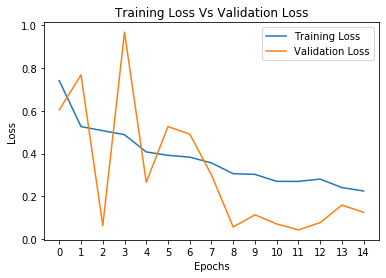

In [57]:
epochs = 15

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(0,epochs)[0::1])
plt.legend()
plt.show()

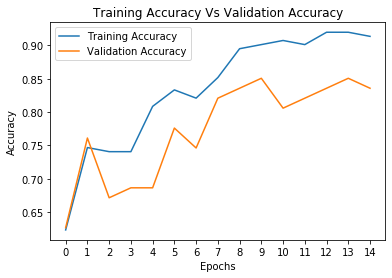

In [102]:
epochs = 15

loss = history_aug.history['acc']
val_loss = history_aug.history['val_acc']

plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(loss, label='Training Accuracy')
plt.plot(val_loss, label='Validation Accuracy')
plt.xticks(range(0,epochs)[0::1])
plt.legend()
plt.show()

### Testing the model

In [68]:
model_aug = load_model('best_weights_CNN_aug.hdf5')
scores = model_aug.evaluate_generator(generator=test_imageGen,steps=624)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 1.6133198738098145
Test accuracy: 0.6442307829856873


In [63]:
test_imageGen.reset()
pred_aug = np.argmax(model_aug.predict_generator(test_imageGen,steps=624),axis=1)

In [64]:
actual_labels = (test_imageGen.labels)

### Evaluating the model

In [99]:
print(metrics.classification_report(actual_labels, pred_aug))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68       234
           1       1.00      0.43      0.60       390

    accuracy                           0.64       624
   macro avg       0.76      0.72      0.64       624
weighted avg       0.82      0.64      0.63       624



### Confusion Matrix

In [67]:
display(pd.crosstab(actual_labels, pred_aug, rownames=["True"],colnames = ['Predicted'], margins = True))

Predicted,0,1,All
True,,,
0,234,0,234
1,222,168,390
All,456,168,624


# Task 5: VGG16 Model

We are using the pre-trained VGG 16 Model.

In [70]:
train_path = 'train'
test_path = 'test'
generator = ImageDataGenerator(validation_split=0.3,rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)
img_height, img_width = 162,128

In [71]:
print("Training Set")
train_batches_2 = generator.flow_from_directory(directory=train_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'], batch_size=16, subset='training', shuffle=False, seed=20)

print("Validation Set")
valid_batches_2 = generator.flow_from_directory(directory=train_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'], batch_size=16, subset='validation', shuffle=False, seed=20)

print("Test Set")
test_batches_2 = test_gen.flow_from_directory(directory=test_path, target_size=(img_height, img_width),
    classes=['NORMAL', 'PNEUMONIA'], batch_size=1, shuffle=False, seed=20)

Training Set
Found 162 images belonging to 2 classes.
Validation Set
Found 67 images belonging to 2 classes.
Test Set
Found 624 images belonging to 2 classes.


### VGG16:
It is a keras application. Keras applications are pre trained models. VGG 16 model has weights pre-trained on ImageNet.

In [69]:
vgg16_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape = (img_height, img_width,3))
display(vgg16_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0     

None

In [72]:
#Adding a few dense layers and assemble the full model

vgg16_last_layer = vgg16_model.output
x1 = Flatten()(vgg16_last_layer)
x2 = Dense(256, activation='relu')(x1)
final_layer = Dense(2, activation = 'softmax')(x2)

In [73]:
full_model = keras.Model(vgg16_model.input, final_layer)

In [74]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 162, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 162, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 162, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 81, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 81, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 81, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 32, 128)       0   

We will be freezing a few layers of the model, while the remaining will be left unfreezed. The weights of the freezed layers will not be updated.

In [83]:
for layer in full_model.layers[:13]:
    layer.trainable = False

In [84]:
print("VGG16 Layers")
for layer in full_model.layers:
    print(layer.name,"->",layer.trainable)

VGG16 Layers
input_1 -> False
block1_conv1 -> False
block1_conv2 -> False
block1_pool -> False
block2_conv1 -> False
block2_conv2 -> False
block2_pool -> False
block3_conv1 -> False
block3_conv2 -> False
block3_conv3 -> False
block3_pool -> False
block4_conv1 -> False
block4_conv2 -> False
block4_conv3 -> True
block4_pool -> True
block5_conv1 -> True
block5_conv2 -> True
block5_conv3 -> True
block5_pool -> True
flatten_3 -> True
dense_7 -> True
dense_8 -> True


### Training the model

In [85]:
full_model.compile(optimizer=Adam(lr=.0001), loss='categorical_crossentropy', metrics=['acc']) #compiling the model

In [86]:
best_weights_filepath = 'best_weights_CNN_vgg16.hdf5' #saving the best weights
checkpoint = ModelCheckpoint(best_weights_filepath, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

In [87]:
train_batches.reset()
valid_batches.reset()
history_vgg16 = full_model.fit_generator(train_batches_2, steps_per_epoch= STEP_SIZE_TRAIN,
                                  validation_data = valid_batches_2, 
                                  validation_steps = STEP_SIZE_VALID, epochs=15, verbose=1, callbacks = [checkpoint])

Epoch 1/15
10/10 [==============================] - 15s 1s/step - loss: 0.7900 - acc: 0.5205 - val_loss: 1.3451 - val_acc: 0.7969

Epoch 00001: loss improved from inf to 0.75393, saving model to best_weights_CNN_vgg16.hdf5
Epoch 2/15
10/10 [==============================] - 14s 1s/step - loss: 0.2434 - acc: 0.9110 - val_loss: 0.3809 - val_acc: 0.8039

Epoch 00002: loss improved from 0.75393 to 0.26232, saving model to best_weights_CNN_vgg16.hdf5
Epoch 3/15
10/10 [==============================] - 15s 2s/step - loss: 0.0595 - acc: 0.9812 - val_loss: 6.3326e-04 - val_acc: 0.7451

Epoch 00003: loss improved from 0.26232 to 0.05945, saving model to best_weights_CNN_vgg16.hdf5
Epoch 4/15
10/10 [==============================] - 15s 1s/step - loss: 0.2896 - acc: 0.9247 - val_loss: 0.1121 - val_acc: 0.9216

Epoch 00004: loss did not improve from 0.05945
Epoch 5/15
10/10 [==============================] - 13s 1s/step - loss: 0.0301 - acc: 0.9924 - val_loss: 0.6792 - val_acc: 0.8039

Epoch 0000

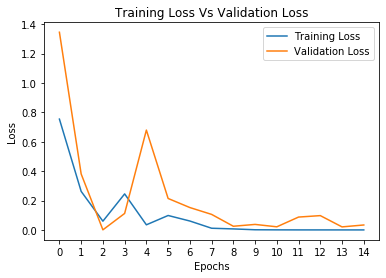

In [90]:
epochs = 15

loss = history_vgg16.history['loss']
val_loss = history_vgg16.history['val_loss']

plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xticks(range(0,epochs)[0::1])
plt.legend()
plt.show()

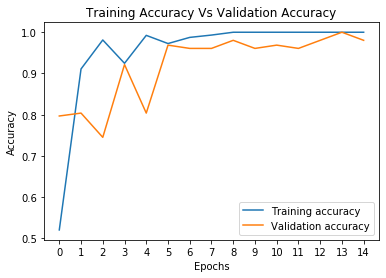

In [100]:
epochs = 15

loss = history_vgg16.history['acc']
val_loss = history_vgg16.history['val_acc']

plt.title('Training Accuracy Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(loss, label='Training accuracy')
plt.plot(val_loss, label='Validation accuracy')
plt.xticks(range(0,epochs)[0::1])
plt.legend()
plt.show()

### Testing the model

In [91]:
full_model = load_model('best_weights_CNN_vgg16.hdf5')
scores = full_model.evaluate_generator(generator=test_batches_2,steps=624)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Test loss: 0.061408236622810364
Test accuracy: 0.8141025900840759


In [92]:
test_batches_2.reset()
pred_vgg = np.argmax(full_model.predict_generator(test_batches_2,steps=624),axis=1)

In [93]:
actual_labels = (test_batches.labels)

### Evaluating the model

In [96]:
print(metrics.classification_report(actual_labels, pred_vgg))

              precision    recall  f1-score   support

           0       0.90      0.57      0.70       234
           1       0.79      0.96      0.87       390

    accuracy                           0.81       624
   macro avg       0.84      0.76      0.78       624
weighted avg       0.83      0.81      0.80       624



### Confusion Matrix

In [97]:
display(pd.crosstab(actual_labels, pred_vgg, rownames=["True"],colnames = ['Predicted'], margins = True))

Predicted,0,1,All
True,,,
0,133,101,234
1,15,375,390
All,148,476,624


# Visualising evaluation metrics

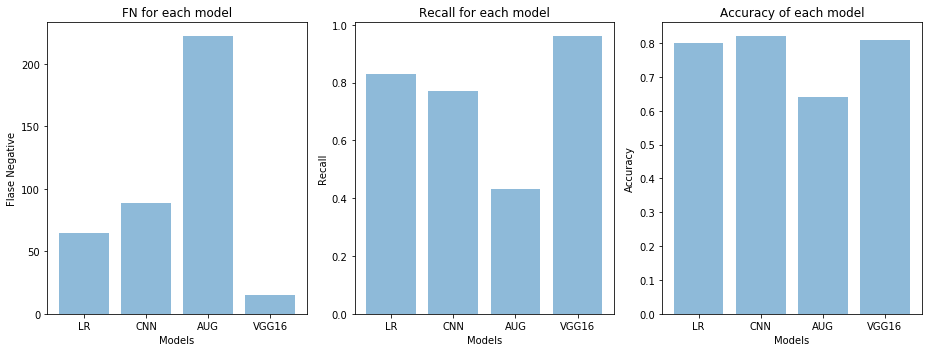

In [109]:
#evauluation plots
plt.figure(figsize=(13,5))

objects = ('LR', 'CNN', 'AUG', 'VGG16')
y_pos = np.arange(len(objects))
performance = [65,89,222,15]
plt.subplot(1, 3, 1)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Flase Negative')
plt.xlabel('Models')
plt.title("FN for each model")

objects = ('LR', 'CNN', 'AUG', 'VGG16')
y_pos = np.arange(len(objects))
performance = [0.83,0.77,0.43,0.96]
plt.subplot(1, 3, 2)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Recall')
plt.xlabel('Models')
plt.title("Recall for each model")

objects = ('LR', 'CNN', 'AUG', 'VGG16')
y_pos = np.arange(len(objects))
performance = [0.8,0.82,0.64,0.81]
plt.subplot(1, 3, 3)
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title("Accuracy of each model")

plt. tight_layout()

plt.show()

# Reflection Report

Test set has 624 images.  We are using the confusion matrix for evaluation.
1 - Pneumonia (positive)
0 - Normal (negative)

We won’t be considering accuracy for evaluation as the dataset is imbalanced. The accuracies for Logistic regression, CNN, CNN with data augmentation and VGG 16 are 0.80, 0.82, 0.64 and 0.81 respectively.

We are considering False Negatives(FN) and recall. FN means that the patient has pneumonia but the model fails to detect it and shows a negative result.

-- Logistic Regression: In the confusion matrix, FN is 65 while the TP is 325. This means out of 390 pneumonia x-ray images in the test set, 325 are correctly predicted, while 65 are not. So we will consider the recall. The recall is 0.83 for Logistic regression.

-- CNN: In the confusion matrix, FN is 89 while the TP is 301. This means out of 390 pneumonia x-ray images in the test set, 301 are correctly predicted, while 89 are not.The recall is 0.77 for CNN.

-- CNN with data augmentation: In the confusion matrix, FN is 222 while the TP is 168. This means out of 390 pneumonia x-ray images in the test set, only 168 are correctly predicted, while 222 are not. The recall is 0.43 for the model.

-- VGG 16 model: In the confusion matrix, FN is 15 while the TP is 375. This means out of 390 pneumonia x-ray images in the test set, 375 are correctly predicted, while 15 are not. The recall is 0.96 for the model.

 Considering the above evaluation, we can conclude VGG 16 performs the best because it has the lowest number of falsely predicted pneumonia x-rays (FN) which results in high recall(0.96). The worst model is CNN with data augmentation because it has the highest number of falsely predicted pneumonia x-rays(FN), which results in low recall (0.43). Models in decreasing order of performance are as follows:

VGG 16 > Logistic Regression > CNN > CNN with data augmentation
 


